In [1]:
# https://hemtools.readthedocs.io/en/latest/content/Bioinformatics_Core_Competencies/Volcanoplot.html
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA

In [12]:
dataset_filename = 'D14' # Only need to use this when D14 is involved -> different filename structure, notice how you have to change the 'dataset'
dataset = "14D"
filename = f"{dataset_filename} v cntl.xlsx"
p_col_name = f'P-value ({dataset} vs Control)'
fdr_col_name = f'FDR step up ({dataset} vs Control)'
fold_change_col_name = f'Fold change ({dataset} vs Control)'

df = pd.read_excel(filename)
df.head()

,Gene ID,Gene name,P-value (14D vs Control),FDR step up (14D vs Control),Ratio (14D vs Control),Fold change (14D vs Control),LSMean(14D) (14D vs Control),LSMean(Control) (14D vs Control),Unnamed: 8,Unnamed: 9
0,0610005C13Rik,0610005C13Rik,0.783923,?,1.282563,1.282563,7.788303,6.072451,NaN,0.105727
1,0610006L08Rik,0610006L08Rik,0.371103,?,0.155003,-6.451478,0.35889,2.315373,NaN,0.430506
2,0610009B22Rik,0610009B22Rik,0.065484,0.252279,0.443589,-2.254338,28.604666,64.484591,NaN,1.183867
3,0610009E02Rik,0610009E02Rik,0.065719,?,5.739945,5.739945,9.569081,1.667103,NaN,1.182309
4,0610009L18Rik,0610009L18Rik,0.776872,0.904435,0.880335,-1.135931,19.076491,21.669576,NaN,0.109651


In [13]:
print(df.columns)
print(df[p_col_name].dtype)
df[p_col_name] = pd.to_numeric(df[p_col_name], errors='coerce')

Index(['Gene ID', 'Gene name', 'P-value (14D vs Control)',
       'FDR step up (14D vs Control)', 'Ratio (14D vs Control)',
       'Fold change (14D vs Control)', 'LSMean(14D) (14D vs Control)',
       'LSMean(Control) (14D vs Control)', 'Unnamed: 8', 'Unnamed: 9'],
      dtype='object')
object


In [14]:
# Lets filter out the rows where the 'FDR step up (D5 vs Control)' == '?'
print('Shape of df before filtering: ', df.shape)
df = df[df[fdr_col_name] != '?']
print('Shape of df after filtering FDR step up, "?": ', df.shape)

# Now we must filter for 'FDR step up (D5 vs Control)' <= 0.05
# df = df[df['FDR step up (D5 vs Control)'] <= 0.05]
# print('Shape of df after filtering FDR step up cutoff, "<= 0.05": ', df.shape)

# Now we must filter for 'P-value (D5 vs Control)' <= 0.05
df = df[df[p_col_name] <= 0.05]
print('Shape of df after filtering P-value cutoff, "<= 0.05": ', df.shape)

# print out some statistics of the Fold Change
print('Mean: ', df[fold_change_col_name].mean())
print('Median: ', df[fold_change_col_name].median())
print('Std: ', df[fold_change_col_name].std())

Shape of df before filtering:  (29383, 10)
Shape of df after filtering FDR step up, "?":  (17977, 10)
Shape of df after filtering P-value cutoff, "<= 0.05":  (4147, 10)
Mean:  9782258.818339897
Median:  1.34080760118265
Std:  628923590.4523104


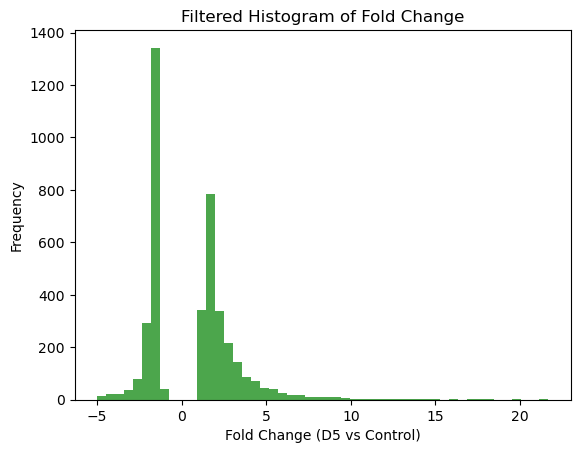

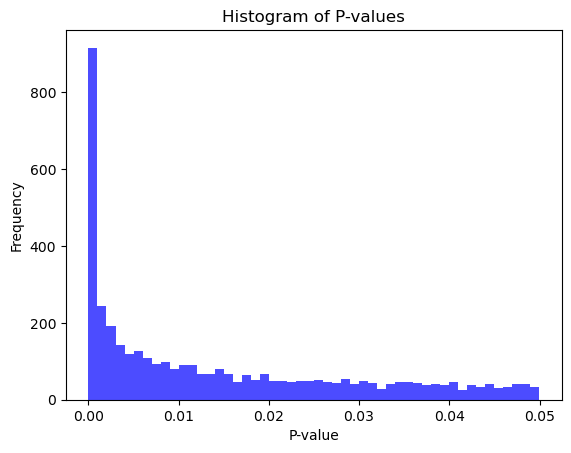

In [ ]:
# Removing extreme outliers for visualization and analysis
q_low = df[fold_change_col_name].quantile(0.01)
q_high = df[fold_change_col_name].quantile(0.99)

df = df[(df[fold_change_col_name] > q_low) & (df[fold_change_col_name] < q_high)]

# Replot histogram with filtered data
plt.hist(df[fold_change_col_name], bins=50, color='green', alpha=0.7)
plt.title('Filtered Histogram of Fold Change')
plt.xlabel('Fold Change (D5 vs Control)')
plt.ylabel('Frequency')
plt.show()


# Plot the histogram of p-values
plt.hist(df[p_col_name], bins=50, color='blue', alpha=0.7)
plt.title('Histogram of P-values')
plt.xlabel('P-value')
plt.ylabel('Frequency')
plt.show()

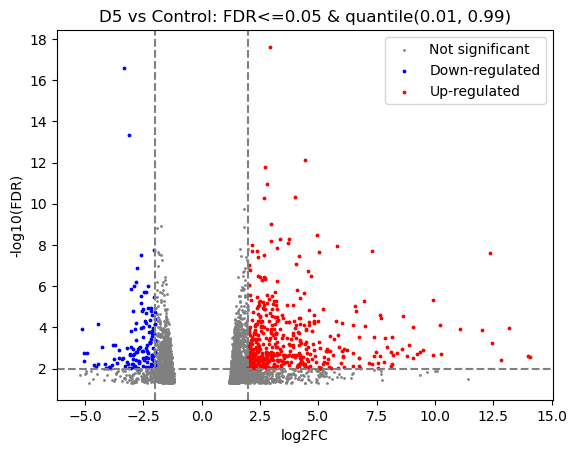

In [12]:
# # Handling non-numeric and zero values before applying log2
df[fold_change_col_name] = pd.to_numeric(df[fold_change_col_name], errors='coerce').replace(0, np.nan)

# # Adding a small value to handle zeroes and negative values if any
# df['Fold change (D5 vs Control)'] += 1e-6

# Applying log2 transformation
# df['logFC'] = np.log2(df['Fold change (D5 vs Control)'])
df['logFC'] = df[fold_change_col_name]

# Plot non-significant points
plt.scatter(
    x=df['logFC'],
    y=df[p_col_name].apply(lambda x: -np.log10(x)),
    s=1,
    label="Not significant",
    color='grey'
)

# Highlight down- or up-regulated genes
down = df[(df['logFC'] <= -2) & (df[p_col_name] <= 0.01)]
up = df[(df['logFC'] >= 2) & (df[p_col_name] <= 0.01)]

plt.scatter(
    x=down['logFC'],
    y=down[p_col_name].apply(lambda x: -np.log10(x)),
    s=3,
    label="Down-regulated",
    color="blue"
)
plt.scatter(
    x=up['logFC'],
    y=up[p_col_name].apply(lambda x: -np.log10(x)),
    s=3,
    label="Up-regulated",
    color="red"
)

# Axes and labels
plt.title(f"{dataset} vs Control: FDR<=0.05 & quantile(0.01, 0.99)")
plt.xlabel("log2FC")
plt.ylabel("-log10(FDR)")
plt.axvline(x=-2, color="grey", linestyle="--")
plt.axvline(x=2, color="grey", linestyle="--")
plt.axhline(y=2, color="grey", linestyle="--")  # Threshold for significance; adjust if different

# Legend and plot display
plt.legend()
plt.show()

In [11]:
from deg_utils import *
deg_filename = 'mRNA_gene.FPKM.csv'
df = read_mrna_gene_expression_files(deg_filename)
df_avg = compute_transcript_avg_counts_conditions(deg_filename)

Shape of df: (21812, 13)
DF Columns after rename: Index(['gene_id', 'Gene Name', 'gene_description', 'gene_locus', 'C_1_237N',
       'C_2_281N', 'C_3_280N', 'D5_1_267N', 'D5_2_284L', 'D5_3_284N',
       'D14_1_237R', 'D14_2_238R', 'D14_3_266R'],
      dtype='object')
              gene_id Gene Name  \
0  ENSMUSG00000025902     Sox17   
1  ENSMUSG00000051951      Xkr4   
2  ENSMUSG00000025900       Rp1   
3  ENSMUSG00000033845    Mrpl15   
4  ENSMUSG00000025903    Lypla1   

                                    gene_description         gene_locus  \
0  SRY (sex determining region Y)-box 17 [Source:...  1:4561154-4567577   
1  X-linked Kx blood group related 4 [Source:MGI ...  1:3276124-3741721   
2  retinitis pigmentosa 1 (human) [Source:MGI Sym...  1:4069780-4479464   
3  mitochondrial ribosomal protein L15 [Source:MG...  1:4843429-4855962   
4  lysophospholipase 1 [Source:MGI Symbol;Acc:MGI...  1:4878011-4918633   

    C_1_237N   C_2_281N  C_3_280N  D5_1_267N  D5_2_284L  D5_3_284N  \

In [ ]:
def load_gene_list(filename):
    with open(filename, 'r') as file:
        gene_list = file.read().strip().splitlines()
        print(f'\n\nGene List: {gene_list}\n\n')
    return gene_list

def filter_data_by_genes(df_avg, gene_list):
    # Assuming 'Gene Name' is the column in `df` that contains the gene identifiers
    # Filter the DataFrame based on the gene list, making it not case sensitive
    df_avg['Gene Name'] = df_avg['Gene Name'].str.upper()
    gene_list = [gene.upper() for gene in gene_list]
    df_avg = df_avg[df_avg['Gene Name'].isin(gene_list)]
    
    print(f'\n\nFiltered Data by Gene DF:\n\n{df_avg}\n\n')

    return df_avg

def reshape_violin_df(df):

    # This function will just transpose the dataframe and then delete any misc columns
    # The end result is a dataframe with gene names on the top, and then the rows are the different samples, they are NOT AVERAGED

    # Delete the following columns: gene_id, gene_description, gene_locus
    df = df.drop(['gene_id', 'gene_description', 'gene_locus'], axis=1)
    # Transpose the DataFrame
    df = df.T
    print(f'\n\nTranspose DataFrame Head:\n\n{df.head()}\n\n')

    # conditions_t = df.iloc[:, 0]
    
    # Reset the index
    df = df.reset_index()
    print(f'\n\nReset Index DataFrame Head:\n\n{df.head()}\n\n')

    conditions_t = df.iloc[:, 0]
    
    # Delete the first column
    df = df.drop(df.columns[0], axis=1)
    # Drop the header and make the first row the column names
    df.columns = df.iloc[0]
    # Drop the first row
    df = df.iloc[1:]
    print(f'\n\nReshaped ViolinDataFrame Head:\n\n{df.head()}\n\n')
    print(f'\n\nReshaped ViolinDataFrame Shape:\n\n{df.shape}\n\n')
    
    return df, conditions_t

def plot_violin(df):
    # Melting the DataFrame so each row is a condition-gene pair with an expression value
    melted_df = df.melt(var_name='Gene', value_name='Expression')
    
    plt.figure(figsize=(12, 8))
    sns.violinplot(x='Gene', y='Expression', data=melted_df, palette='muted', scale='width')
    plt.title('Gene Expression Levels by Gene')
    plt.xlabel('Gene')
    plt.ylabel('Expression Level')
    plt.xticks(rotation=90)  # Rotate x labels for better readability, as you might have many genes
    plt.tight_layout()  # Adjust layout to make room for label rotation
    plt.show()

def plot_gene_violin(df, gene):
    melted_df = df.melt(var_name='Condition', value_name='Expression')
    
    plt.figure(figsize=(12, 8))
    sns.violinplot(x='Condition', y='Expression', data=melted_df[melted_df['Gene'] == gene], palette='muted', scale='width')
    plt.title(f'Expression Levels of {gene} by Condition')
    plt.xlabel('Condition')
    plt.ylabel('Expression Level')
    plt.show()

def plot_heatmap(df_avg):
    # Assuming the row index is 'Gene Name' and columns are the conditions
    plt.figure(figsize=(12, 8))
    sns.heatmap(df_avg.set_index('Gene Name'), annot=True, cmap='viridis', cbar=True)
    plt.title('Heatmap of Gene Expression')
    plt.xlabel('Condition')
    plt.ylabel('Gene')
    plt.show()

def plot_pca(normalized_counts):
    # Perform PCA
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(normalized_counts)

    # Create a DataFrame for plotting
    pca_df = pd.DataFrame(data = pca_results, columns = ['PC1', 'PC2'])
    pca_df['sample'] = normalized_counts.index

    # Plot PCA
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='sample', data=pca_df, palette='viridis', s=100)
    plt.title('PCA Plot of Bulk RNA-seq Data')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()


In [53]:
# Load the gene list
gene_list_filename = 'gene_list.txt'
gene_list = load_gene_list(gene_list_filename)

filtered_df = filter_data_by_genes(df, gene_list) # filtering df for Violin plot

filtered_df, conditions_t = reshape_violin_df(filtered_df) # reshaping df for violin-friendly input

filtered_avg_df = filter_data_by_genes(df_avg, gene_list) # filtering df_avg for Heatmap plot





Gene List: ['TBX1', 'MYF6', 'SIX2', 'CREBBP', 'LRG1', 'EP300', 'RNF111', 'HIPK2', 'BMPR2', 'FOXF1', 'NF1', 'PKD2', 'TBX2', 'SPEF1', 'NAV3', 'ATXN7', 'TAOK1', 'FOXC1', 'SEMA6A', 'HIPK1', 'RUNX1', 'SPRED1', 'AGO2', 'STAB1', 'ANGPTL4', 'EPHA1', 'S100A9', 'S100A8', 'USP7', 'CSRP3', 'PIEZO1', 'CLN3', 'MYCBP2', 'SHANK1']




Filtered Data by Gene DF:

                  gene_id Gene Name  \
240    ENSMUSG00000067336     BMPR2   
1752   ENSMUSG00000027351    SPRED1   
1958   ENSMUSG00000027329     SPEF1   
2822   ENSMUSG00000056054    S100A8   
2823   ENSMUSG00000056071    S100A9   
2993   ENSMUSG00000008730     HIPK1   
4906   ENSMUSG00000034462      PKD2   
5629   ENSMUSG00000061436     HIPK2   
6969   ENSMUSG00000038738    SHANK1   
7086   ENSMUSG00000030470     CSRP3   
8664   ENSMUSG00000042812     FOXF1   
8686   ENSMUSG00000014444    PIEZO1   
9281   ENSMUSG00000032217    RNF111   
10362  ENSMUSG00000035923      MYF6   
10370  ENSMUSG00000020181      NAV3   
11245  ENSMUSG00000017291 

In [55]:
# print(conditions_t)
# print index of conditions_t
# print(filtered_df.index)
# print(f'Data type of conditions_t: {type(conditions_t)}')

# conver to list
# conditions_list = conditions_t.tolist()
# print(f'Data type of conditions_t: {type(conditions_t)}')
print(conditions_t)

RangeIndex(start=0, stop=10, step=1)


/tmp/ipykernel_1689/547864877.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Gene', y='Expression', data=melted_df, palette='muted', scale='width')
/tmp/ipykernel_1689/547864877.py:44: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x='Gene', y='Expression', data=melted_df, palette='muted', scale='width')


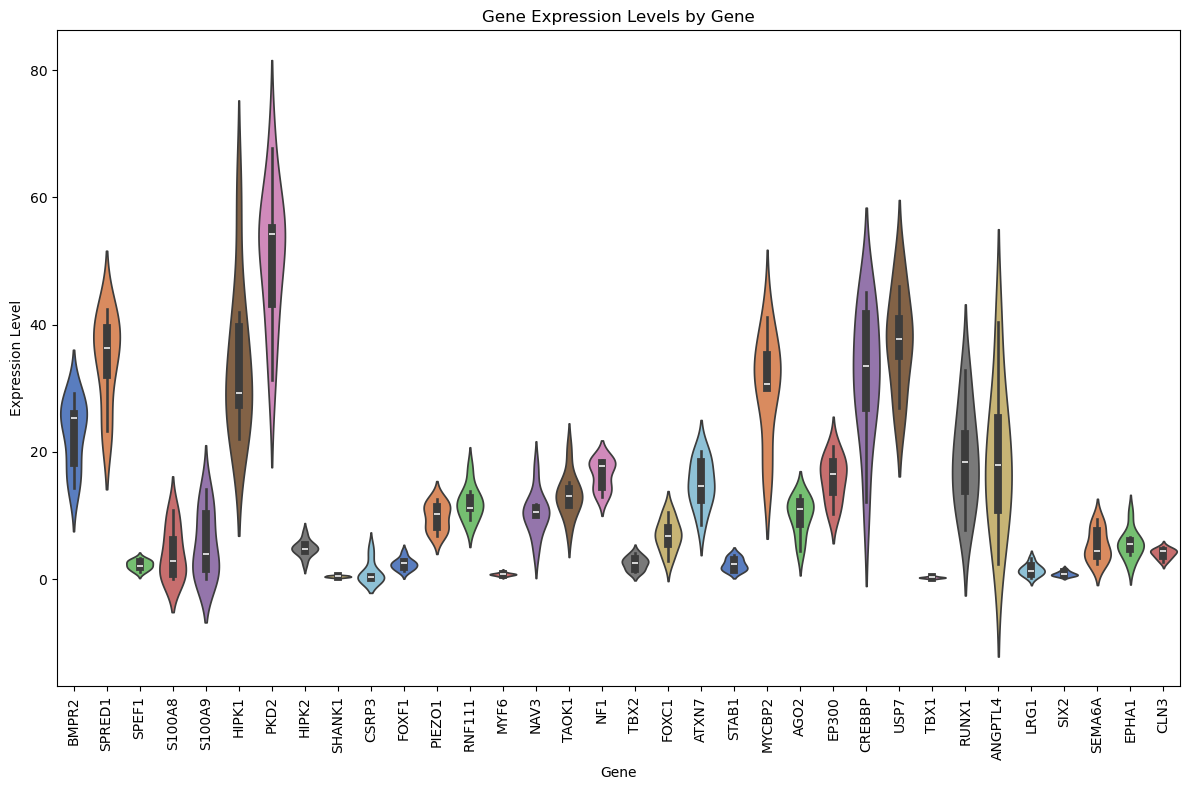

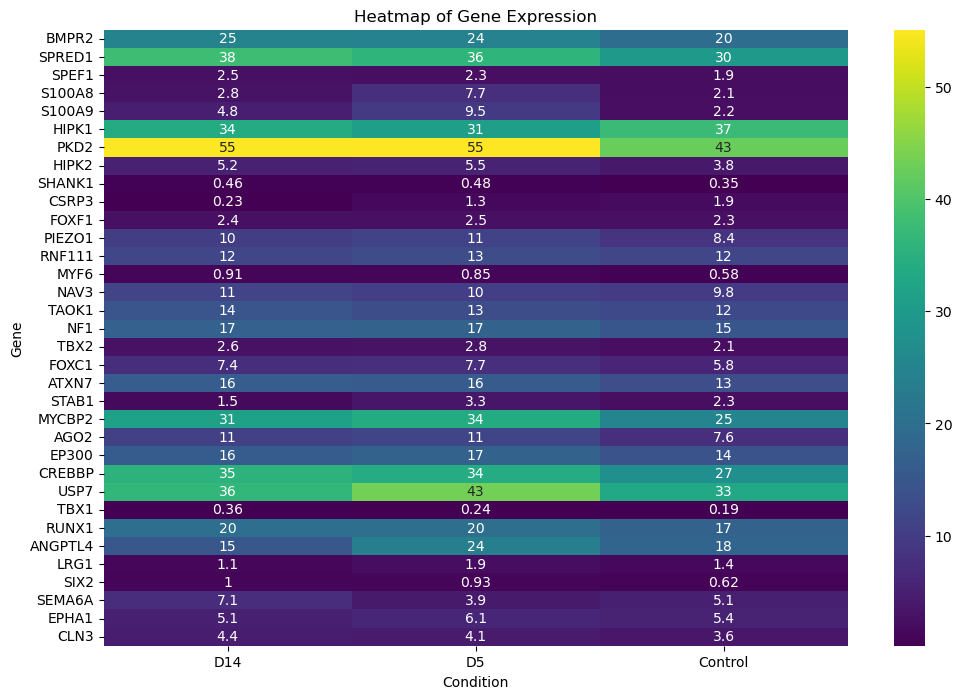

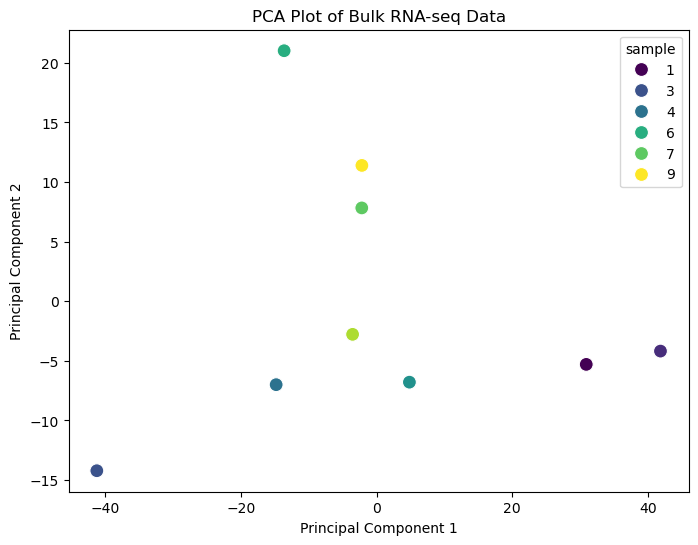

In [19]:
# Create the plots
plot_violin(filtered_df)
plot_heatmap(filtered_avg_df)
plot_pca(filtered_df)
